<a href="https://colab.research.google.com/github/jared-ni/cs2241-final/blob/main/5_9_2025_outline_image_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

In [2]:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import kagglehub
import os
import pathlib
import matplotlib.pyplot as plt
import time

print("TensorFlow Version:", tf.__version__)

gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"Found GPU: {gpu_devices[0].name}. Training will be accelerated.")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print("No GPU found. Training will run on CPU (might be slow).")
    print("Runtime > Change runtime type > Hardware accelerator > GPU")

TensorFlow Version: 2.18.0
Found GPU: /physical_device:GPU:0. Training will be accelerated.


In [22]:
import kagglehub
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import pathlib

# data_root = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
# data_root = kagglehub.dataset_download("alessiocorrado99/animals10")

# data_dir = os.path.join(data_root, 'raw-img')

data_root = '/content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed'

data_dir = os.path.join(data_root, "raw-img")

print("Path to dataset files:", data_dir)

Path to dataset files: /content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed/raw-img


In [5]:
from tensorflow import keras
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip "/content/animals10_10k_outline-dictionary-quant2bit.zip" -d "/content/animals10_10k_outline-dictionary-quant2bit"

In [ ]:
!unzip "/content/kaggle-animals10_10k_outlines_img.zip" -d "/content/kaggle-animals10_10k_outlines_img"

In [ ]:
!unzip "/content/kaggle-animals10_10k_outlines_npy.zip" -d "/content/kaggle-animals10_10k_outlines_npy"

In [ ]:
!unzip "/content/animals10_10k_outline-quant2bit_count-min_fpp01_0101.zip" -d "/content/animals10_10k_outline-quant2bit_count-min_fpp01_0101"

In [50]:
import os
import shutil
import random
from tqdm import tqdm

# output_base_dir = "/content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed"
# output_base_dir = "/content/kaggle-animals10_10k_outlines_img/kaggle-animals10_10k_outlines_img/raw-img"
output_base_dir = "/content/animals10_10k_outline-quant2bit_count-min_fpp01_0101/animals10_10k_outline-quant2bit_count-min_fpp01_0101/decompressed/raw-img"

# Output folders
output_dirs = {
    'train': os.path.join(output_base_dir, 'train'),
    'val': os.path.join(output_base_dir, 'val'),
    'test': os.path.join(output_base_dir, 'test')
}

# Classes (folder names in PetImages/)
# classes = ['Cat', 'Dog']
# classes = ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
classes = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
split_ratio = [0.8, 0.1, 0.1]

# Create output folders
for split in output_dirs:
    for cls in classes:
        os.makedirs(os.path.join(output_dirs[split], cls), exist_ok=True)

print("Path to output files:", output_dirs)
# Split images
for cls in classes:
    src_folder = os.path.join(data_dir, cls)
    # all_files = [f for f in os.listdir(src_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.npy'))]
    all_files = [f for f in os.listdir(src_folder) ]
    random.shuffle(all_files)

    total_used = 1000

    train_cutoff = int(total_used * split_ratio[0])
    val_cutoff = int(total_used * (split_ratio[0] + split_ratio[1]))

    splits = {
        'train': all_files[:train_cutoff],
        'val': all_files[train_cutoff:val_cutoff],
        'test': all_files[val_cutoff:total_used]
    }

    for split, files in splits.items():
        for f in tqdm(files, desc=f"Copying {cls} to {split}"):
            src = os.path.join(src_folder, f)
            dst = os.path.join(output_dirs[split], cls, f)
            try:
                shutil.copyfile(src, dst)
            except Exception as e:
                pass  # Skip corrupted files


Path to output files: {'train': '/content/animals10_10k_outline-quant2bit_count-min_fpp01_0101/animals10_10k_outline-quant2bit_count-min_fpp01_0101/decompressed/raw-img/train', 'val': '/content/animals10_10k_outline-quant2bit_count-min_fpp01_0101/animals10_10k_outline-quant2bit_count-min_fpp01_0101/decompressed/raw-img/val', 'test': '/content/animals10_10k_outline-quant2bit_count-min_fpp01_0101/animals10_10k_outline-quant2bit_count-min_fpp01_0101/decompressed/raw-img/test'}


Copying squirrel to test: 100%|██████████| 100/100 [00:00<00:00, 1654.91it/s]


In [25]:
# IMAGENET FEATURE MAP EXTRACTION (512, 7, 7)
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os

# 1. Load VGG16 pre-trained on ImageNet
print("Loading VGG16 pre-trained on ImageNet...")
vgg16 = models.vgg16(pretrained=True)
print("Model loaded.")

# Get the convolutional base (features)
spatial_feature_extractor_vgg = vgg16.features

# Freeze the weights of the pre-trained layers
for param in spatial_feature_extractor_vgg.parameters():
    param.requires_grad = False

# Set the model to evaluation mode (important for dropout if it were present, or batch norm if it were ResNet etc.)
spatial_feature_extractor_vgg.eval() # Do this once after setup

print("\nVGG16 Spatial Feature Extractor created and set to eval mode.")
print(f"Conceptual output shape (spatial features for 224x224 input): (Batch_Size, 512, 7, 7)")

img_height, img_width = 224, 224

preprocess = transforms.Compose([
    # 1. Resize the image
    transforms.Resize((img_height, img_width)),
    # 2. Convert PIL Image to PyTorch Tensor
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Loading VGG16 pre-trained on ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 217MB/s]


Model loaded.

VGG16 Spatial Feature Extractor created and set to eval mode.
Conceptual output shape (spatial features for 224x224 input): (Batch_Size, 512, 7, 7)


In [26]:
def extract_features_from_image_path(image_path: str) -> torch.Tensor:
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at: {image_path}")
    try:
        # Load the image using PIL
        img_pil = Image.open(image_path)
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')
        processed_img_th = preprocess(img_pil)
        input_tensor = processed_img_th.unsqueeze(0)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        raise
    with torch.no_grad():
        spatial_features = spatial_feature_extractor_vgg(input_tensor)
    return spatial_features

my_image_path = '/kaggle/split_data/test/Cat/100.jpg'
stats_output_file = 'feature_map_stats.txt'
full_feature_map_file = 'full_feature_map.txt'

if not os.path.exists(my_image_path):
    print(f"Example image not found at {my_image_path}. Please update the path.")
else:
    print(f"\n--- Extracting features for {my_image_path} ---")

# get the feature map
feature_map = extract_features_from_image_path(my_image_path)

# Print the shape and some info to console
print(f"\nSuccessfully extracted feature map.")
print(f"Feature map shape: {feature_map.shape}")
print(f"Feature map dtype: {feature_map.dtype}")

# --- Calculate summary statistics ---
min_val = torch.min(feature_map)
max_val = torch.max(feature_map)
mean_val = torch.mean(feature_map)
std_val = torch.std(feature_map)

# --- Print summary statistics to console ---
print("\n--- Summary statistics of the extracted feature map ---")
print(f"Min value: {min_val}")
print(f"Max value: {max_val}")
print(f"Mean value: {mean_val}")
print(f"Standard deviation: {std_val}")

# --- Optional: Print a slice to console ---
print("\n--- Slice of the feature map (Batch 0, first 5 channels, H=0, W=0) ---")
print(feature_map[0, :5, 0, 0])


# --- Write summary statistics to the stats text file ---
print(f"\nWriting summary statistics to {stats_output_file}...")
with open(stats_output_file, 'w') as f:
    f.write(f"Feature Map Statistics for Image: {my_image_path}\n")
    f.write("-" * 40 + "\n")
    f.write(f"Feature map shape: {feature_map.shape}\n")
    f.write(f"Feature map dtype: {feature_map.dtype}\n")
    f.write("-" * 40 + "\n")
    f.write(f"Min value: {min_val.item()}\n") # Use .item() to get scalar value
    f.write(f"Max value: {max_val.item()}\n")
    f.write(f"Mean value: {mean_val.item()}\n")
    f.write(f"Standard deviation: {std_val.item()}\n")
    f.write("-" * 40 + "\n")

    print(f"Summary statistics successfully written to {stats_output_file}.")
    print(f"\nWriting the FULL feature map content to {full_feature_map_file}...")

np.save("feature_map_nparray.npy", feature_map.numpy())

Example image not found at /kaggle/split_data/test/Cat/100.jpg. Please update the path.


FileNotFoundError: Image file not found at: /kaggle/split_data/test/Cat/100.jpg

In [27]:
# IMAGENET 4096 FEATURE EXTRACTION SETUP
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image # Import PIL for loading images
import numpy as np
import os
import traceback # Import traceback for detailed error printing

# 1. Load VGG16 pre-trained on ImageNet
print("Loading VGG16 pre-trained on ImageNet...")
vgg16 = models.vgg16(pretrained=True)
print("Model loaded.")

# 2. Create the feature extractor as a custom Module, explicitly handling Flatten
class VGG16FeatureExtractor4096(nn.Module):
    def __init__(self, original_vgg16):
        super().__init__()
        # Keep the convolutional base (output is 512x7x7 for 224x224 input)
        self.features = original_vgg16.features

        # Manually add the Flatten layer
        self.flatten = nn.Flatten()

        self.classifier_head = nn.Sequential(
             original_vgg16.classifier[0], # First Linear layer (25088 -> 4096)
             original_vgg16.classifier[1]  # ReLU after it
        )

        for param in original_vgg16.parameters():
             param.requires_grad = False
    def forward(self, x):
        # Pass through the convolutional base
        x = self.features(x) # Output shape: (Batch, 512, 7, 7)
        x = self.flatten(x) # Expected output shape: (Batch, 512 * 7 * 7) = (Batch, 25088)
        x = self.classifier_head(x) # Output shape: (Batch, 4096)
        return x

# Instantiate the custom feature extractor
feature_extractor_vgg_4096 = VGG16FeatureExtractor4096(vgg16)
feature_extractor_vgg_4096.eval()

print("\nVGG16 4096-element Feature Extractor (Custom Module V2) created and set to eval mode.")
print(f"Conceptual output shape (4096 features for 224x224 input): (Batch_Size, 4096)")

img_height, img_width = 224, 224

preprocess = transforms.Compose([
    transforms.Resize((img_height, img_width)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("\nPreprocessing pipeline imagenet 4096 defined.")

Loading VGG16 pre-trained on ImageNet...
Model loaded.

VGG16 4096-element Feature Extractor (Custom Module V2) created and set to eval mode.
Conceptual output shape (4096 features for 224x224 input): (Batch_Size, 4096)

Preprocessing pipeline imagenet 4096 defined.


In [35]:
def extract_4096_features_from_image_path(image_path: str) -> torch.Tensor:
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at: {image_path}")
    try:
        img_pil = Image.open(image_path)
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')
        processed_img_th = preprocess(img_pil)
        input_tensor = processed_img_th.unsqueeze(0)

    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        raise # Re-raise the exception

    with torch.no_grad():
        features_4096 = feature_extractor_vgg_4096(input_tensor)

    return features_4096


def extract_4096_features_from_npy_path(npy_path: str) -> torch.Tensor:
    if not os.path.exists(npy_path):
        raise FileNotFoundError(f"NPY file not found at: {npy_path}")

    try:
        # 1. Load the numpy array from the .npy file
        img_array_np = np.load(npy_path)

        # 2. Convert numpy array to PyTorch tensor
        processed_img_th = torch.from_numpy(img_array_np)

        # 3. Ensure the tensor is float32, as most models expect this
        if processed_img_th.dtype != torch.float32:
            processed_img_th = processed_img_th.float()

        # 4. Standardize tensor dimensions to (C, H, W)
        if processed_img_th.ndim == 2:  # Shape (H, W)
            # Assume grayscale, add channel dimension: (1, H, W)
            processed_img_th = processed_img_th.unsqueeze(0)
        elif processed_img_th.ndim == 4:  # Shape (B, C, H, W)
            if processed_img_th.shape[0] == 1:
                # Remove batch dimension if it's 1: (C, H, W)
                processed_img_th = processed_img_th.squeeze(0)
            else:
                raise ValueError(
                    f"NPY file at {npy_path} contains a batch of {processed_img_th.shape[0]} images. "
                    "This function expects an NPY file with a single image tensor."
                )
        elif processed_img_th.ndim == 3:  # Shape (C, H, W)
            # Already in the desired C, H, W format, do nothing here
            pass
        else:
            raise ValueError(
                f"Unexpected tensor dimensions in NPY file: {processed_img_th.shape}. "
                "Expected 2 (H,W), 3 (C,H,W), or 4 (1,C,H,W)."
            )
        # At this point, processed_img_th should be (C, H, W)

        # 5. Ensure 3 channels (e.g., for VGG-like models)
        # If it's single channel (C=1), repeat it to make 3 channels
        num_channels = processed_img_th.shape[0]
        if num_channels == 1:
            processed_img_th = processed_img_th.repeat(3, 1, 1)  # Becomes (3, H, W)
        elif num_channels != 3:
            raise ValueError(
                f"Image tensor from {npy_path} has {num_channels} channels, but 3 are expected "
                f"(or 1, to be converted to 3). Shape: {processed_img_th.shape}"
            )
        # Now processed_img_th is (3, H, W)

        # 6. Add batch dimension for the model: (1, 3, H, W)
        input_tensor = processed_img_th.unsqueeze(0)

    except Exception as e:
        print(f"Error processing NPY file {npy_path}: {e}")
        raise  # Re-raise the exception

    # 7. Extract features (no gradient calculation needed)
    with torch.no_grad():
        # If your feature_extractor_vgg_4096 model is on a specific device (e.g., GPU),
        # you should ensure input_tensor is also on that device.
        # Example:
        # device = next(feature_extractor_vgg_4096.parameters()).device # Get model's device
        # input_tensor = input_tensor.to(device)
        features_4096 = feature_extractor_vgg_4096(input_tensor)

    return features_4096

In [12]:

# Make sure you have an image file at this path!
my_image_path = '/kaggle/split_data-animals10/test/cane/OIP--OzHmoOBxcUQs7N3KjButwHaFP.jpeg' # <--- Use your specific test path
feature_vector_output_file = 'image_feature_vector_4096.txt' # <--- Define the output file path

if not os.path.exists(my_image_path):
    print(f"Example image not found at {my_image_path}. Please update the path.")
else:
    print(f"\n--- Extracting 4096 features for {my_image_path} ---")
    # Call the function to get the 4096 feature vector
    feature_vector_4096 = extract_4096_features_from_image_path(my_image_path)

    # Print the shape and some info
    print(f"\nSuccessfully extracted 4096 feature vector.")
    print(f"Feature vector shape: {feature_vector_4096.shape}") # Should be (1, 4096)
    print(f"Feature vector dtype: {feature_vector_4096.dtype}")

    print("\n--- Summary statistics of the extracted 4096 feature vector ---")
    print(f"Min value: {torch.min(feature_vector_4096).item()}")
    print(f"Max value: {torch.max(feature_vector_4096).item()}")
    print(f"Mean value: {torch.mean(feature_vector_4096).item()}")
    print(f"Standard deviation: {torch.std(feature_vector_4096).item()}")

    # --- Write the FULL 4096 feature vector to a text file ---
    print(f"\nWriting the FULL 4096 feature vector to {feature_vector_output_file}...")

    # The tensor is (1, 4096). We want the 4096 values from the first (and only) item in the batch.
    # Convert the tensor to a NumPy array, then flatten it to a 1D array, then convert to a list.
    feature_list = feature_vector_4096.tolist()
    feature_string = str(feature_list)

    # Write this string representation to the file
    with open(feature_vector_output_file, 'w') as f:
        f.write(f"Feature Vector (4096 elements) for Image: {my_image_path}\n")
        f.write("-" * 40 + "\n")
        f.write(f"Shape: {feature_vector_4096.shape}, Dtype: {feature_vector_4096.dtype}\n")
        f.write("-" * 40 + "\n")
        # Write the single, potentially very long, string
        f.write(feature_string)
        f.write("\n") # Add a newline at the end
    np.save("feature_vector_4096_nparray.npy", feature_vector_4096.numpy())

Example image not found at /kaggle/split_data-animals10/test/cane/OIP--OzHmoOBxcUQs7N3KjButwHaFP.jpeg. Please update the path.


In [31]:
def process_dataset_and_save_features(input_base_dir, output_base_dir):
    """
    Iterates through the dataset directory structure, extracts features for each image,
    and saves them as .npy files in a mirrored directory structure.
    """
    if not os.path.exists(input_base_dir):
        print(f"ERROR: Input dataset directory not found: {input_base_dir}")
        return

    print(f"\nStarting feature extraction for dataset at: {input_base_dir}")
    print(f"Features will be saved under: {output_base_dir}")

    # Ensure the main output directory exists
    os.makedirs(output_base_dir, exist_ok=True)

    # Iterate through 'test', 'train', 'val' subfolders
    for split_name in os.listdir(input_base_dir):
        split_dir = os.path.join(input_base_dir, split_name)
        if not os.path.isdir(split_dir):
            continue
        print(f"\nProcessing split: {split_name}")

        # Create corresponding split directory in output
        output_split_dir = os.path.join(output_base_dir, split_name)
        os.makedirs(output_split_dir, exist_ok=True)

        # Iterate through 'Cat', 'Dog' sub-subfolders
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            print(f"  Processing class: {class_name}")

            # Create corresponding class directory in output
            output_class_dir = os.path.join(output_split_dir, class_name)
            os.makedirs(output_class_dir, exist_ok=True)

            # Iterate through images in the class directory
            processed_in_class_count = 0
            image_files_in_class = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]

            for image_name in image_files_in_class:
                image_path = os.path.join(class_dir, image_name)

                # Construct the output feature file path
                base_name, _ = os.path.splitext(image_name)
                feature_file_name = f"{base_name}_feature_vector.npy"
                feature_file_path = os.path.join(output_class_dir, feature_file_name)

                try:
                    # Extract the 4096 feature vector (PyTorch tensor, shape (1, 4096))
                    # feature_vector_tensor = extract_4096_features_from_image_path(image_path)
                    feature_vector_tensor = extract_4096_features_from_npy_path(image_path)


                    # Convert to NumPy array and remove the batch dimension
                    # Squeeze(0) converts from (1, 4096) to (4096,)
                    feature_vector_np = feature_vector_tensor.squeeze(0).numpy()

                    # Save the NumPy array
                    np.save(feature_file_path, feature_vector_np)

                    processed_in_class_count += 1
                    if processed_in_class_count % 50 == 0 or processed_in_class_count == len([f for f in image_files_in_class]): # Log progress
                        valid_image_count = len([f for f in image_files_in_class])
                        print(f"    Saved features for {processed_in_class_count}/{valid_image_count} images in {split_name}/{class_name}...")

                except Exception as e:
                    print(f"    ERROR extracting/saving features for {image_name}: {e}")
                    # traceback.print_exc() # Uncomment for full traceback if needed for debugging

            print(f"  Finished processing class {class_name}. Extracted features for {processed_in_class_count} images.")
        print(f"Finished processing split {split_name}.")

    print("\nAll feature extraction complete.")


In [36]:
# Process the dataset
# PROCESS THE Features

INPUT_DATA_BASE_DIR = '/content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed-split'
OUTPUT_FEATURES_BASE_DIR = '/content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed-features'


process_dataset_and_save_features(INPUT_DATA_BASE_DIR, OUTPUT_FEATURES_BASE_DIR)


Starting feature extraction for dataset at: /content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed-split
Features will be saved under: /content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed-features

Processing split: val
  Processing class: butterfly
    Saved features for 50/100 images in val/butterfly...
    Saved features for 100/100 images in val/butterfly...
  Finished processing class butterfly. Extracted features for 100 images.
  Processing class: squirrel
    Saved features for 50/100 images in val/squirrel...
    Saved features for 100/100 images in val/squirrel...
  Finished processing class squirrel. Extracted features for 100 images.
  Processing class: dog
    Saved features for 50/100 images in val/dog...
    Saved features for 100/100 images in val/dog...
  Finished processing class dog. Extracted features for 100 images.
  Processing class: elephant
    Saved fea

In [ ]:
!zip -r /content/feature_vectors-animals10.zip /kaggle/feature_vectors-animals10
from google.colab import files
files.download("/content/feature_vectors-animals10.zip")

In [ ]:
!unzip "/content/3-bloomier-fpp-experiments.zip" -d "/content/3-bloomier-fpp-experiments"

In [37]:
# ------------------------------------------------------------
# --- Imports ---
# ------------------------------------------------------------
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader # For data loading and batching
from sklearn.model_selection import train_test_split # Still useful if you needed to split data here


# ------------------------------------------------------------
# --- Configuration ---
# ------------------------------------------------------------
# Path to the directory where you saved the extracted feature vectors
# !!! CHANGE THIS TO YOUR ACTUAL SAVED FEATURES PATH !!!
# SAVED_FEATURES_BASE_DIR = '/content/decompressed_4bit-quant_count-min_05/decompressed_05_everything'

# Label mapping (must match how features were extracted)
# Ensure these map to 0 and 1 for binary classification
# LABEL_MAP = {'Cat': 0, 'Dog': 1} # Cat = 0, Dog = 1
# LABEL_MAP = {'cane': 0, 'cavallo': 1, 'elefante': 2, 'farfalla': 3, 'gallina': 4, 'gatto': 5,
#              'mucca': 6, 'pecora': 7, 'ragno': 8, 'scoiattolo': 9}
LABEL_MAP = {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5,
             'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}

# --- Classifier Model Parameters ---
INPUT_FEATURE_DIM = 4096 # VGG16 4096 feature vector size
# NUM_CLASSES = 2
NUM_CLASSES = 10

# --- Training Hyperparameters ---
EPOCHS = 50 # Number of training epochs (you might adjust this)
BATCH_SIZE = 8 # Training batch size (you might adjust this)
LEARNING_RATE = 0.001 # Learning rate for optimizer (Adam is a good default)

# --- Device Configuration ---
# Use GPU if available, otherwise use CPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# ------------------------------------------------------------
# --- Data Loading Function (from .npy files) ---
# ------------------------------------------------------------

def load_features_and_labels_from_dir(features_base_dir, split_name, label_map):
    """
    Loads feature vectors and labels from .npy files saved in a directory structure.

    Args:
        features_base_dir: The base directory containing the split folders (e.g., '/kaggle/feature_vectors').
        split_name: The name of the split folder to load ('train', 'val', or 'test').
        label_map: Dictionary mapping class names (folder names) to numerical labels.

    Returns:
        A tuple containing:
        - features: A NumPy array of shape (num_samples, INPUT_FEATURE_DIM).
        - labels: A NumPy array of shape (num_samples,) containing numerical labels.
    """
    split_dir = os.path.join(features_base_dir, split_name)
    if not os.path.exists(split_dir):
        raise FileNotFoundError(f"Split directory not found: {split_dir}")

    all_features = []
    all_labels = []

    print(f"Loading features from split: {split_dir}")

    # Iterate through class folders ('Cat', 'Dog') based on the provided label_map
    for class_name, label in label_map.items():
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.isdir(class_dir):
            print(f"  Warning: Class directory not found: {class_dir}. Skipping.")
            continue

        print(f"  Loading features for class: {class_name}")
        npy_files = [f for f in os.listdir(class_dir) if f.lower().endswith('.npy')]

        loaded_count = 0
        for npy_file in npy_files:
            file_path = os.path.join(class_dir, npy_file)
            try:
                # Load the .npy file
                feature_vector = np.load(file_path)

                # Ensure the shape is correct (should be (4096,))
                if feature_vector.shape != (INPUT_FEATURE_DIM,):
                    print(f"    Warning: Unexpected shape {feature_vector.shape} for {npy_file}. Skipping.")
                    continue

                all_features.append(feature_vector)
                all_labels.append(label) # Append the numerical label

                loaded_count += 1
                if loaded_count > 0 and loaded_count % 1000 == 0: # Print progress
                     print(f"    Loaded {loaded_count}/{len(npy_files)} files for {class_name}...")

            except Exception as e:
                print(f"    Error loading {npy_file}: {e}. Skipping.")

        print(f"  Finished loading {loaded_count} files for class {class_name}.")


    # Convert lists to NumPy arrays
    features = np.array(all_features)
    labels = np.array(all_labels)

    print(f"Finished loading split {split_name}.")
    print(f"  Loaded {len(features)} total samples.")

    return features, labels


class FeatureDataset(Dataset):
    """Custom Dataset for loading feature vectors and labels."""
    def __init__(self, features_np, labels_np):
        self.features = torch.from_numpy(features_np).float()
        self.labels = torch.from_numpy(labels_np).long()

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


class FeatureClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=NUM_CLASSES):
        super().__init__()
        # Simple feed-forward network (MLP)
        self.layer_1 = nn.Linear(input_dim, 256) # Input layer to hidden layer 1
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.5) # Dropout for regularization

        # Optional: Add another hidden layer if needed
        # self.layer_2 = nn.Linear(256, 128)
        # self.relu_2 = nn.ReLU()
        # self.dropout_2 = nn.Dropout(0.5)

        # Output layer
        # Output size is num_classes (2 for Cat/Dog)
        self.output_layer = nn.Linear(256, num_classes) # Connect last hidden layer to output

    def forward(self, x):
        # Define the forward pass
        x = self.layer_1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)

        # If you added layer_2:
        # x = self.layer_2(x)
        # x = self.relu_2(x)
        # x = self.dropout_2(x)

        x = self.output_layer(x)
        return x


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model.train() # Set model to training mode

    for epoch in range(num_epochs):
        running_loss = 0.0
        train_corrects = 0
        train_total = 0

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move data to device

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track training statistics
            running_loss += loss.item() * inputs.size(0) # Accumulate loss
            _, predicted = torch.max(outputs.data, 1)     # Get predicted class
            train_total += labels.size(0)                 # Count total samples
            train_corrects += (predicted == labels).sum().item() # Count correct predictions

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = train_corrects / train_total

        # Evaluation on validation set
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f'Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Set model back to training mode for the next epoch
        model.train()


def evaluate_model(model, data_loader, criterion, device):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    corrects = 0
    total = 0

    # Disable gradient calculation for evaluation
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device) # Move data to device

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            corrects += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = corrects / total

    return epoch_loss, epoch_acc

Using device: cuda


Using device: cuda
Number of training samples: 8000
Number of validation samples: 1000
Classes: {'butterfly': 0, 'cat': 1, 'chicken': 2, 'cow': 3, 'dog': 4, 'elephant': 5, 'horse': 6, 'sheep': 7, 'spider': 8, 'squirrel': 9}
Epoch [1/25], Batch [10/250], Train Loss: 2.3043
Epoch [1/25], Batch [20/250], Train Loss: 2.2935
Epoch [1/25], Batch [30/250], Train Loss: 2.2824
Epoch [1/25], Batch [40/250], Train Loss: 2.2529
Epoch [1/25], Batch [50/250], Train Loss: 2.2643
Epoch [1/25], Batch [60/250], Train Loss: 2.1975
Epoch [1/25], Batch [70/250], Train Loss: 2.1562
Epoch [1/25], Batch [80/250], Train Loss: 2.0509
Epoch [1/25], Batch [90/250], Train Loss: 2.0927
Epoch [1/25], Batch [100/250], Train Loss: 2.2299
Epoch [1/25], Batch [110/250], Train Loss: 2.1877
Epoch [1/25], Batch [120/250], Train Loss: 2.1416
Epoch [1/25], Batch [130/250], Train Loss: 2.2523
Epoch [1/25], Batch [140/250], Train Loss: 1.9498
Epoch [1/25], Batch [150/250], Train Loss: 2.1394
Epoch [1/25], Batch [160/250], Trai

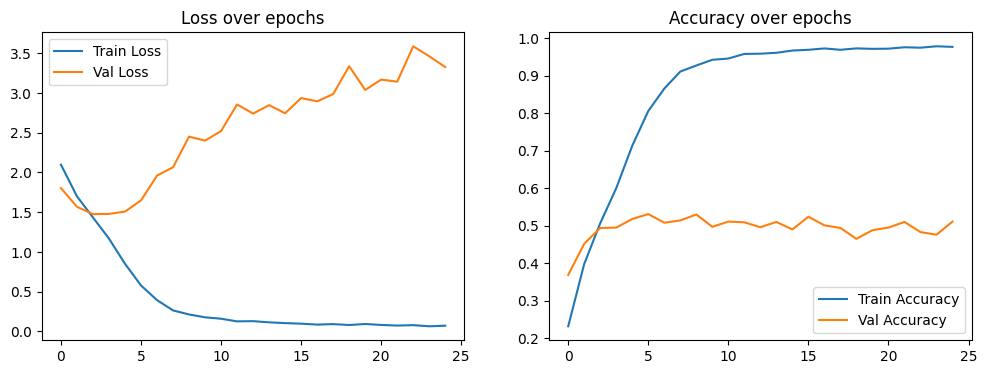


Evaluating on Test Set...
Test Accuracy: 0.4890 on 1000 samples.
Done.


In [39]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split # For splitting val if not explicitly given
from PIL import Image # Only for potential future use or creating dummy npy, not for loading npy
import matplotlib.pyplot as plt

# --- Configuration ---
BASE_DATA_DIR = "/content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed-split"
NUM_CLASSES = 10 # butterfly, cat, chicken, cow, dog, elephant, horse, sheep, spider, squirrel
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 25 # Adjust as needed
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Custom Dataset for .npy files ---
class NpyImageDataset(Dataset):
    def __init__(self, file_paths, labels, class_to_idx, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            # Load the numpy array
            img_array_np = np.load(img_path) # Expected shape (H, W) or (C, H, W)

            # Convert to PyTorch tensor
            img_tensor = torch.from_numpy(img_array_np).float()

            # --- Preprocessing specific to .npy content ---
            # Assuming .npy files might be raw pixel values [0, 255] or similar.
            # If they are already normalized to [0,1] or Z-score normalized, adjust this.
            # For this example, let's assume they are not scaled to [0,1] yet.
            # If values are already e.g. -1 to 1 or 0 to 1, you might skip division by 255.
            if torch.max(img_tensor) > 1.1: # Heuristic: if max val > 1.1, assume it's [0,255] like
                img_tensor = img_tensor / 255.0

            # Ensure correct shape (C, H, W)
            if img_tensor.ndim == 2:  # Shape (H, W) -> (1, H, W)
                img_tensor = img_tensor.unsqueeze(0)

            # Ensure 3 channels (e.g., for models expecting RGB)
            # If .npy is grayscale (1, H, W), repeat to (3, H, W)
            if img_tensor.shape[0] == 1:
                img_tensor = img_tensor.repeat(3, 1, 1)
            elif img_tensor.shape[0] != 3:
                raise ValueError(f"Image tensor from {img_path} has {img_tensor.shape[0]} channels, "
                                 f"expected 1 or 3. Shape: {img_tensor.shape}")

            # Ensure correct H, W
            if img_tensor.shape[1:] != IMAGE_SIZE:
                 # This case should ideally not happen if .npy are already 224x224
                 # If it does, you might need to add resizing here (e.g., using transforms.Resize)
                 # For now, we'll raise an error if not 224x224.
                 raise ValueError(f"Image {img_path} is {img_tensor.shape[1:]}, expected {IMAGE_SIZE}")


        except Exception as e:
            print(f"Error loading or processing {img_path}: {e}")
            # Return a dummy tensor and label to avoid crashing DataLoader, or handle differently
            # For simplicity, we'll re-raise for now to catch issues.
            raise

        if self.transform:
            img_tensor = self.transform(img_tensor)

        return img_tensor, label

# --- 2. Define the CNN Model ---
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(SimpleCNN, self).__init__()
        # Input: (Batch, 3, 224, 224)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # (B, 16, 224, 224)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)      # (B, 16, 112, 112)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)# (B, 32, 112, 112)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)      # (B, 32, 56, 56)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)# (B, 64, 56, 56)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)      # (B, 64, 28, 28)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)# (B, 128, 28, 28)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)      # (B, 128, 14, 14)

        # Flatten
        # Output size from conv layers: 128 channels * 14 * 14 feature map size
        self.fc1_input_features = 128 * 14 * 14
        self.fc1 = nn.Linear(self.fc1_input_features, 512)
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))

        x = x.view(-1, self.fc1_input_features) # Flatten

        x = self.dropout(self.relu_fc1(self.fc1(x)))
        x = self.fc2(x)
        return x

# --- Helper function to load data paths and labels ---
def load_data_from_structure(data_split_dir):
    all_file_paths = []
    all_labels = []
    class_names = sorted([d for d in os.listdir(data_split_dir) if os.path.isdir(os.path.join(data_split_dir, d))])

    if not class_names:
        print(f"Warning: No class directories found in {data_split_dir}")
        return [], [], {}

    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_split_dir, class_name)
        # Using glob to find .npy files, case-insensitive if needed on some OS
        npy_files = glob.glob(os.path.join(class_dir, '*.npy')) + \
                    glob.glob(os.path.join(class_dir, '*.NPY'))

        for npy_file in npy_files:
            all_file_paths.append(npy_file)
            all_labels.append(class_to_idx[class_name])

    return all_file_paths, all_labels, class_to_idx

# --- Training Function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_model_path = "best_animal_cnn.pth"

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % 10 == 0: # Print every 10 batches
                 print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")


        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")

    print("Training complete.")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs, best_model_path


# --- Main Execution ---
if __name__ == '__main__':
    # Define transformations
    # The NpyImageDataset handles initial tensor creation, scaling, and channel shaping.
    # This transform is applied *after* those steps.
    # ImageNet mean and std are common for RGB images.
    data_transforms = transforms.Compose([
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Load data
    train_dir = os.path.join(BASE_DATA_DIR, "train")
    val_dir = os.path.join(BASE_DATA_DIR, "val")
    test_dir = os.path.join(BASE_DATA_DIR, "test")

    if not os.path.exists(train_dir):
        print(f"Error: Training directory {train_dir} not found.")
        print("Please ensure your data is structured correctly: decompressed-split/{train,val,test}/{class_name}/image.npy")
        exit()

    train_files, train_labels, class_to_idx = load_data_from_structure(train_dir)
    if not train_files:
        print("No training files found. Exiting.")
        exit()

    # If val set is not explicitly defined, split from train (optional)
    if not os.path.exists(val_dir) or not os.listdir(val_dir):
        print(f"Validation directory {val_dir} not found or empty. Splitting from training data.")
        if len(train_files) < 20: # Need enough samples to split
            print("Not enough training samples to create a validation set. Using training set for validation (not recommended).")
            val_files, val_labels = train_files, train_labels # Not ideal, just for code to run
        else:
            train_files, val_files, train_labels, val_labels = train_test_split(
                train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
            )
        print(f"Created validation set with {len(val_files)} samples.")
    else:
        val_files, val_labels, _ = load_data_from_structure(val_dir) # class_to_idx should be consistent
        if not val_files:
            print("No validation files found despite directory existing. Check contents. Exiting.")
            exit()


    train_dataset = NpyImageDataset(train_files, train_labels, class_to_idx, transform=data_transforms)
    val_dataset = NpyImageDataset(val_files, val_labels, class_to_idx, transform=data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    print(f"Classes: {class_to_idx}")
    if NUM_CLASSES != len(class_to_idx):
        print(f"Warning: NUM_CLASSES is {NUM_CLASSES} but found {len(class_to_idx)} classes in data.")
        # Potentially update NUM_CLASSES = len(class_to_idx) here if dynamic adjustment is desired.

    # Initialize model, criterion, optimizer
    model = SimpleCNN(num_classes=len(class_to_idx)).to(DEVICE) # Use actual number of classes found
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train the model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)
    train_losses, val_losses, train_accs, val_accs, best_model_path = history

    # Plot training history (optional)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    plt.savefig("training_history.png")
    plt.show()

    # --- Evaluate on Test Set (using the best model) ---
    if os.path.exists(test_dir) and os.listdir(test_dir):
        print("\nEvaluating on Test Set...")
        test_files, test_labels, _ = load_data_from_structure(test_dir)
        if test_files:
            test_dataset = NpyImageDataset(test_files, test_labels, class_to_idx, transform=data_transforms)
            test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

            # Load the best model
            model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
            model.eval()

            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

            test_acc = correct_test / total_test
            print(f"Test Accuracy: {test_acc:.4f} on {total_test} samples.")
        else:
            print("No files found in test directory.")
    else:
        print(f"Test directory {test_dir} not found or empty. Skipping test evaluation.")

    print("Done.")

Using device: cuda
Found 10 classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Number of training samples: 8000
Number of validation samples: 1000
Freezing convolutional layers...
Replaced ResNet18 classifier for 10 classes.
Epoch [1/50], Batch [10/250], Train Loss: 2.4176
Epoch [1/50], Batch [20/250], Train Loss: 2.1822
Epoch [1/50], Batch [30/250], Train Loss: 1.9034
Epoch [1/50], Batch [40/250], Train Loss: 1.9226
Epoch [1/50], Batch [50/250], Train Loss: 1.5966
Epoch [1/50], Batch [60/250], Train Loss: 1.7440
Epoch [1/50], Batch [70/250], Train Loss: 1.8105
Epoch [1/50], Batch [80/250], Train Loss: 1.5126
Epoch [1/50], Batch [90/250], Train Loss: 1.4080
Epoch [1/50], Batch [100/250], Train Loss: 1.5006
Epoch [1/50], Batch [110/250], Train Loss: 1.5177
Epoch [1/50], Batch [120/250], Train Loss: 1.7116
Epoch [1/50], Batch [130/250], Train Loss: 1.5413
Epoch [1/50], Batch [140/250], Train Loss: 1.3905
Epoch [1/50], Batch [150/250

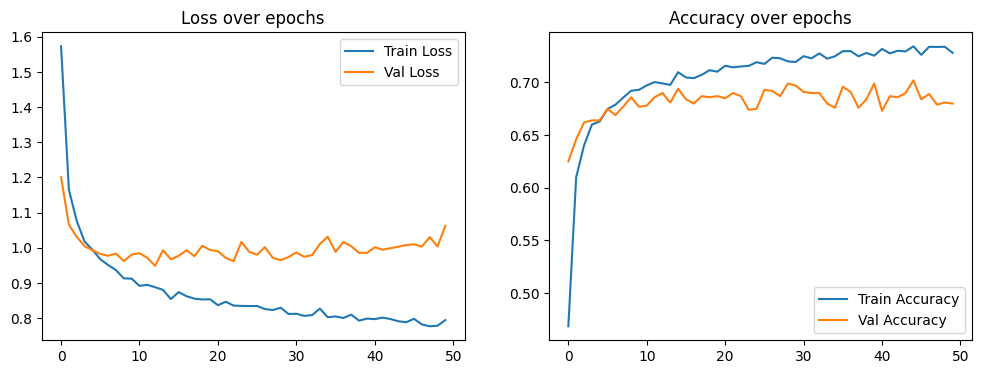


Evaluating on Test Set...
Test Accuracy (best model): 0.6680 on 1000 samples.
Done.


In [41]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models # Added models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Configuration ---
BASE_DATA_DIR = "/content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed-split"
NUM_CLASSES = 10 # Will be dynamically set based on data
IMAGE_SIZE = (224, 224) # ResNet18 expects 224x224
BATCH_SIZE = 32
LEARNING_RATE = 0.001 # Can often be a bit higher when only training classifier
NUM_EPOCHS = 50 # Usually requires fewer epochs for fine-tuning classifier
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Custom Dataset for .npy files (same as before) ---
class NpyImageDataset(Dataset):
    def __init__(self, file_paths, labels, class_to_idx, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            img_array_np = np.load(img_path)
            img_tensor = torch.from_numpy(img_array_np).float()

            if torch.max(img_tensor) > 1.1: # Heuristic for [0,255]
                img_tensor = img_tensor / 255.0

            if img_tensor.ndim == 2:
                img_tensor = img_tensor.unsqueeze(0)

            if img_tensor.shape[0] == 1:
                img_tensor = img_tensor.repeat(3, 1, 1)
            elif img_tensor.shape[0] != 3:
                raise ValueError(f"Image tensor from {img_path} has {img_tensor.shape[0]} channels, "
                                 f"expected 1 or 3. Shape: {img_tensor.shape}")

            if img_tensor.shape[1:] != IMAGE_SIZE:
                 raise ValueError(f"Image {img_path} is {img_tensor.shape[1:]}, expected {IMAGE_SIZE}")

        except Exception as e:
            print(f"Error loading or processing {img_path}: {e}")
            raise

        if self.transform:
            img_tensor = self.transform(img_tensor) # Apply ImageNet normalization here

        return img_tensor, label

# --- 2. Function to get and modify pre-trained model ---
def get_pretrained_resnet18(num_classes, freeze_conv=True):
    # Use the new 'weights' API for clarity
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)

    if freeze_conv:
        print("Freezing convolutional layers...")
        for param in model.parameters():
            param.requires_grad = False

    # Replace the final fully connected layer (the classifier)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    # The new model.fc layer will have requires_grad=True by default

    print(f"Replaced ResNet18 classifier for {num_classes} classes.")
    # Verify which parameters are trainable
    # print("Trainable parameters:")
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(name)

    return model

# --- Helper function to load data paths and labels (same as before) ---
def load_data_from_structure(data_split_dir):
    all_file_paths = []
    all_labels = []
    class_names = sorted([d for d in os.listdir(data_split_dir) if os.path.isdir(os.path.join(data_split_dir, d))])

    if not class_names:
        print(f"Warning: No class directories found in {data_split_dir}")
        return [], [], {}

    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_split_dir, class_name)
        npy_files = glob.glob(os.path.join(class_dir, '*.npy')) + \
                    glob.glob(os.path.join(class_dir, '*.NPY'))

        for npy_file in npy_files:
            all_file_paths.append(npy_file)
            all_labels.append(class_to_idx[class_name])

    return all_file_paths, all_labels, class_to_idx

# --- Training Function (Modified optimizer part) ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_model_path = "best_finetuned_resnet18.pth"

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % 10 == 0:
                 print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")

    print("Training complete.")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs, best_model_path


# --- Main Execution ---
if __name__ == '__main__':
    # Define transformations: CRUCIAL for pre-trained models
    # Use the normalization stats ResNet was trained with on ImageNet
    imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
    # The NpyImageDataset handles initial tensor creation from npy, scaling, and channel shaping.
    # The imagenet_normalize is applied after those steps.
    data_transforms = transforms.Compose([
        imagenet_normalize
    ])

    # Load data
    train_dir = os.path.join(BASE_DATA_DIR, "train")
    val_dir = os.path.join(BASE_DATA_DIR, "val")
    test_dir = os.path.join(BASE_DATA_DIR, "test")

    if not os.path.exists(train_dir):
        print(f"Error: Training directory {train_dir} not found.")
        exit()

    train_files, train_labels, class_to_idx = load_data_from_structure(train_dir)
    if not train_files:
        print("No training files found. Exiting.")
        exit()

    actual_num_classes = len(class_to_idx)
    print(f"Found {actual_num_classes} classes: {list(class_to_idx.keys())}")


    if not os.path.exists(val_dir) or not os.listdir(val_dir):
        print(f"Validation directory {val_dir} not found or empty. Splitting from training data.")
        if len(train_files) < 20:
            print("Not enough training samples for validation. Using training set (not recommended).")
            val_files, val_labels = train_files, train_labels
        else:
            train_files, val_files, train_labels, val_labels = train_test_split(
                train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
            )
    else:
        val_files, val_labels, _ = load_data_from_structure(val_dir)
        if not val_files:
            print("No validation files found. Exiting.")
            exit()

    train_dataset = NpyImageDataset(train_files, train_labels, class_to_idx, transform=data_transforms)
    val_dataset = NpyImageDataset(val_files, val_labels, class_to_idx, transform=data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")

    # Initialize model
    model = get_pretrained_resnet18(num_classes=actual_num_classes, freeze_conv=True).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    # IMPORTANT: Only optimize the parameters of the new classifier
    # If you froze layers, only parameters with requires_grad=True will be updated.
    # For ResNet18, the new classifier is model.fc
    params_to_optimize = model.fc.parameters()
    # If you decided to unfreeze more layers later, you'd collect all params with requires_grad=True:
    # params_to_optimize = [p for p in model.parameters() if p.requires_grad]

    optimizer = optim.Adam(params_to_optimize, lr=LEARNING_RATE)

    # Train the model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)
    train_losses, val_losses, train_accs, val_accs, best_model_path = history

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    plt.savefig("finetuning_resnet18_history.png")
    plt.show()

    # Evaluate on Test Set
    if os.path.exists(test_dir) and os.listdir(test_dir):
        print("\nEvaluating on Test Set...")
        test_files, test_labels, _ = load_data_from_structure(test_dir)
        if test_files:
            test_dataset = NpyImageDataset(test_files, test_labels, class_to_idx, transform=data_transforms)
            test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

            model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
            model.eval()

            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

            test_acc = correct_test / total_test
            print(f"Test Accuracy (best model): {test_acc:.4f} on {total_test} samples.")
        else:
            print("No files found in test directory.")
    else:
        print(f"Test directory {test_dir} not found or empty. Skipping test evaluation.")

    print("Done.")

Using device: cuda
Found 10 classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Number of training samples: 8000
Number of validation samples: 1000
Freezing convolutional layers...
Replaced ResNet18 classifier for 10 classes.
Epoch [1/50], Batch [10/250], Train Loss: 2.4719
Epoch [1/50], Batch [20/250], Train Loss: 2.0986
Epoch [1/50], Batch [30/250], Train Loss: 1.9725
Epoch [1/50], Batch [40/250], Train Loss: 1.8903
Epoch [1/50], Batch [50/250], Train Loss: 1.9272
Epoch [1/50], Batch [60/250], Train Loss: 1.8469
Epoch [1/50], Batch [70/250], Train Loss: 1.6215
Epoch [1/50], Batch [80/250], Train Loss: 1.3773
Epoch [1/50], Batch [90/250], Train Loss: 1.6558
Epoch [1/50], Batch [100/250], Train Loss: 1.5728
Epoch [1/50], Batch [110/250], Train Loss: 1.6705
Epoch [1/50], Batch [120/250], Train Loss: 1.4024
Epoch [1/50], Batch [130/250], Train Loss: 1.3756
Epoch [1/50], Batch [140/250], Train Loss: 1.3432
Epoch [1/50], Batch [150/250

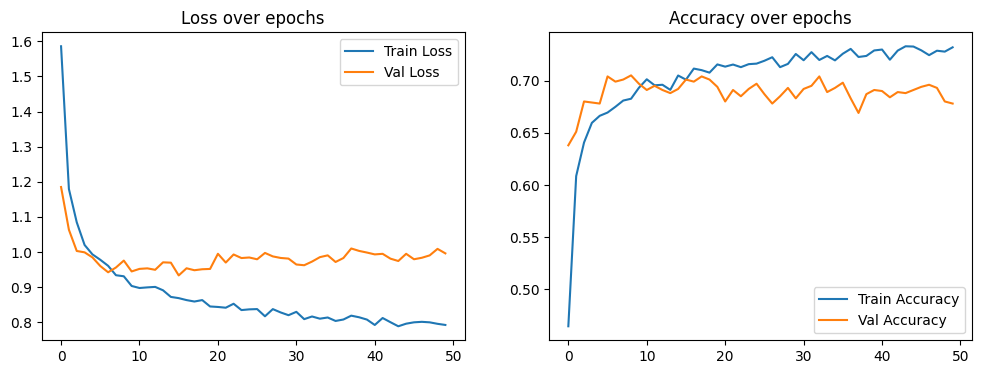


Evaluating on Test Set...
Test Accuracy (best model): 0.6640 on 1000 samples.
Done.


In [47]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models # Added models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Configuration ---
BASE_DATA_DIR = "/content/kaggle-animals10_10k_outlines_npy/kaggle-animals10_10k_outlines_npy/split-data"
NUM_CLASSES = 10 # Will be dynamically set based on data
IMAGE_SIZE = (224, 224) # ResNet18 expects 224x224
BATCH_SIZE = 32
LEARNING_RATE = 0.001 # Can often be a bit higher when only training classifier
NUM_EPOCHS = 50 # Usually requires fewer epochs for fine-tuning classifier
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Custom Dataset for .npy files (same as before) ---
class NpyImageDataset(Dataset):
    def __init__(self, file_paths, labels, class_to_idx, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            img_array_np = np.load(img_path)
            img_tensor = torch.from_numpy(img_array_np).float()

            if torch.max(img_tensor) > 1.1: # Heuristic for [0,255]
                img_tensor = img_tensor / 255.0

            if img_tensor.ndim == 2:
                img_tensor = img_tensor.unsqueeze(0)

            if img_tensor.shape[0] == 1:
                img_tensor = img_tensor.repeat(3, 1, 1)
            elif img_tensor.shape[0] != 3:
                raise ValueError(f"Image tensor from {img_path} has {img_tensor.shape[0]} channels, "
                                 f"expected 1 or 3. Shape: {img_tensor.shape}")

            if img_tensor.shape[1:] != IMAGE_SIZE:
                 raise ValueError(f"Image {img_path} is {img_tensor.shape[1:]}, expected {IMAGE_SIZE}")

        except Exception as e:
            print(f"Error loading or processing {img_path}: {e}")
            raise

        if self.transform:
            img_tensor = self.transform(img_tensor) # Apply ImageNet normalization here

        return img_tensor, label

# --- 2. Function to get and modify pre-trained model ---
def get_pretrained_resnet18(num_classes, freeze_conv=True):
    # Use the new 'weights' API for clarity
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)

    if freeze_conv:
        print("Freezing convolutional layers...")
        for param in model.parameters():
            param.requires_grad = False

    # Replace the final fully connected layer (the classifier)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    # The new model.fc layer will have requires_grad=True by default

    print(f"Replaced ResNet18 classifier for {num_classes} classes.")
    # Verify which parameters are trainable
    # print("Trainable parameters:")
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(name)

    return model

# --- Helper function to load data paths and labels (same as before) ---
def load_data_from_structure(data_split_dir):
    all_file_paths = []
    all_labels = []
    class_names = sorted([d for d in os.listdir(data_split_dir) if os.path.isdir(os.path.join(data_split_dir, d))])

    if not class_names:
        print(f"Warning: No class directories found in {data_split_dir}")
        return [], [], {}

    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_split_dir, class_name)
        npy_files = glob.glob(os.path.join(class_dir, '*.npy')) + \
                    glob.glob(os.path.join(class_dir, '*.NPY'))

        for npy_file in npy_files:
            all_file_paths.append(npy_file)
            all_labels.append(class_to_idx[class_name])

    return all_file_paths, all_labels, class_to_idx

# --- Training Function (Modified optimizer part) ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_model_path = "best_finetuned_resnet18.pth"

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % 10 == 0:
                 print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")

    print("Training complete.")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs, best_model_path


# --- Main Execution ---
if __name__ == '__main__':
    # Define transformations: CRUCIAL for pre-trained models
    # Use the normalization stats ResNet was trained with on ImageNet
    imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
    # The NpyImageDataset handles initial tensor creation from npy, scaling, and channel shaping.
    # The imagenet_normalize is applied after those steps.
    data_transforms = transforms.Compose([
        imagenet_normalize
    ])

    # Load data
    train_dir = os.path.join(BASE_DATA_DIR, "train")
    val_dir = os.path.join(BASE_DATA_DIR, "val")
    test_dir = os.path.join(BASE_DATA_DIR, "test")

    if not os.path.exists(train_dir):
        print(f"Error: Training directory {train_dir} not found.")
        exit()

    train_files, train_labels, class_to_idx = load_data_from_structure(train_dir)
    if not train_files:
        print("No training files found. Exiting.")
        exit()

    actual_num_classes = len(class_to_idx)
    print(f"Found {actual_num_classes} classes: {list(class_to_idx.keys())}")


    if not os.path.exists(val_dir) or not os.listdir(val_dir):
        print(f"Validation directory {val_dir} not found or empty. Splitting from training data.")
        if len(train_files) < 20:
            print("Not enough training samples for validation. Using training set (not recommended).")
            val_files, val_labels = train_files, train_labels
        else:
            train_files, val_files, train_labels, val_labels = train_test_split(
                train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
            )
    else:
        val_files, val_labels, _ = load_data_from_structure(val_dir)
        if not val_files:
            print("No validation files found. Exiting.")
            exit()

    train_dataset = NpyImageDataset(train_files, train_labels, class_to_idx, transform=data_transforms)
    val_dataset = NpyImageDataset(val_files, val_labels, class_to_idx, transform=data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")

    # Initialize model
    model = get_pretrained_resnet18(num_classes=actual_num_classes, freeze_conv=True).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    # IMPORTANT: Only optimize the parameters of the new classifier
    # If you froze layers, only parameters with requires_grad=True will be updated.
    # For ResNet18, the new classifier is model.fc
    params_to_optimize = model.fc.parameters()
    # If you decided to unfreeze more layers later, you'd collect all params with requires_grad=True:
    # params_to_optimize = [p for p in model.parameters() if p.requires_grad]

    optimizer = optim.Adam(params_to_optimize, lr=LEARNING_RATE)

    # Train the model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)
    train_losses, val_losses, train_accs, val_accs, best_model_path = history

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    plt.savefig("finetuning_resnet18_history.png")
    plt.show()

    # Evaluate on Test Set
    if os.path.exists(test_dir) and os.listdir(test_dir):
        print("\nEvaluating on Test Set...")
        test_files, test_labels, _ = load_data_from_structure(test_dir)
        if test_files:
            test_dataset = NpyImageDataset(test_files, test_labels, class_to_idx, transform=data_transforms)
            test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

            model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
            model.eval()

            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

            test_acc = correct_test / total_test
            print(f"Test Accuracy (best model): {test_acc:.4f} on {total_test} samples.")
        else:
            print("No files found in test directory.")
    else:
        print(f"Test directory {test_dir} not found or empty. Skipping test evaluation.")

    print("Done.")

Using device: cuda
Found 10 classes: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']
Number of training samples: 8000
Number of validation samples: 1000
Freezing convolutional layers...
Replaced ResNet18 classifier for 10 classes.
Epoch [1/25], Batch [10/250], Train Loss: 2.1729
Epoch [1/25], Batch [20/250], Train Loss: 1.9700
Epoch [1/25], Batch [30/250], Train Loss: 1.9842
Epoch [1/25], Batch [40/250], Train Loss: 1.7642
Epoch [1/25], Batch [50/250], Train Loss: 1.7065
Epoch [1/25], Batch [60/250], Train Loss: 1.7332
Epoch [1/25], Batch [70/250], Train Loss: 1.6628
Epoch [1/25], Batch [80/250], Train Loss: 1.7147
Epoch [1/25], Batch [90/250], Train Loss: 1.5384
Epoch [1/25], Batch [100/250], Train Loss: 1.4723
Epoch [1/25], Batch [110/250], Train Loss: 1.5603
Epoch [1/25], Batch [120/250], Train Loss: 1.6075
Epoch [1/25], Batch [130/250], Train Loss: 1.2466
Epoch [1/25], Batch [140/250], Train Loss: 1.2115
Epoch [1/25], Batch [150/250

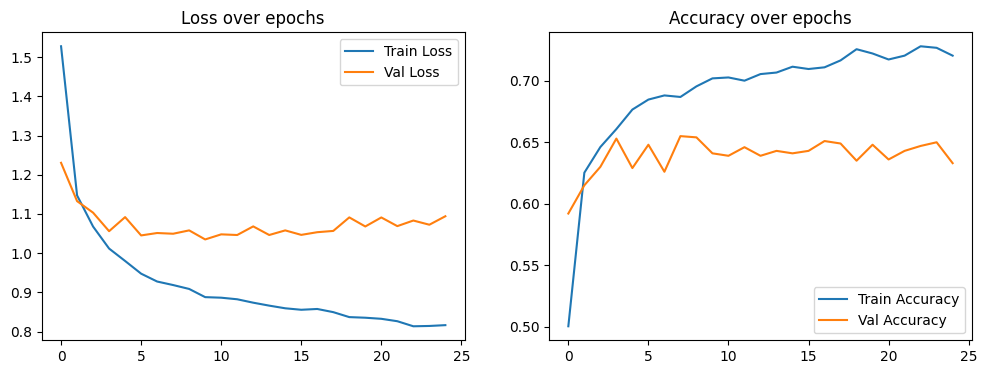


Evaluating on Test Set...
Test Accuracy (best model): 0.6430 on 1000 samples.
Done.


In [51]:
import os
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models # Added models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# --- Configuration ---
BASE_DATA_DIR = "/content/animals10_10k_outline-quant2bit_count-min_fpp01_0101/animals10_10k_outline-quant2bit_count-min_fpp01_0101/split-data"
NUM_CLASSES = 10 # Will be dynamically set based on data
IMAGE_SIZE = (224, 224) # ResNet18 expects 224x224
BATCH_SIZE = 32
LEARNING_RATE = 0.001 # Can often be a bit higher when only training classifier
NUM_EPOCHS = 25 # Usually requires fewer epochs for fine-tuning classifier
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- 1. Custom Dataset for .npy files (same as before) ---
class NpyImageDataset(Dataset):
    def __init__(self, file_paths, labels, class_to_idx, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.class_to_idx = class_to_idx
        self.idx_to_class = {v: k for k, v in class_to_idx.items()}
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]

        try:
            img_array_np = np.load(img_path)
            img_tensor = torch.from_numpy(img_array_np).float()

            if torch.max(img_tensor) > 1.1: # Heuristic for [0,255]
                img_tensor = img_tensor / 255.0

            if img_tensor.ndim == 2:
                img_tensor = img_tensor.unsqueeze(0)

            if img_tensor.shape[0] == 1:
                img_tensor = img_tensor.repeat(3, 1, 1)
            elif img_tensor.shape[0] != 3:
                raise ValueError(f"Image tensor from {img_path} has {img_tensor.shape[0]} channels, "
                                 f"expected 1 or 3. Shape: {img_tensor.shape}")

            if img_tensor.shape[1:] != IMAGE_SIZE:
                 raise ValueError(f"Image {img_path} is {img_tensor.shape[1:]}, expected {IMAGE_SIZE}")

        except Exception as e:
            print(f"Error loading or processing {img_path}: {e}")
            raise

        if self.transform:
            img_tensor = self.transform(img_tensor) # Apply ImageNet normalization here

        return img_tensor, label

# --- 2. Function to get and modify pre-trained model ---
def get_pretrained_resnet18(num_classes, freeze_conv=True):
    # Use the new 'weights' API for clarity
    weights = models.ResNet18_Weights.IMAGENET1K_V1
    model = models.resnet18(weights=weights)

    if freeze_conv:
        print("Freezing convolutional layers...")
        for param in model.parameters():
            param.requires_grad = False

    # Replace the final fully connected layer (the classifier)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    # The new model.fc layer will have requires_grad=True by default

    print(f"Replaced ResNet18 classifier for {num_classes} classes.")
    # Verify which parameters are trainable
    # print("Trainable parameters:")
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(name)

    return model

# --- Helper function to load data paths and labels (same as before) ---
def load_data_from_structure(data_split_dir):
    all_file_paths = []
    all_labels = []
    class_names = sorted([d for d in os.listdir(data_split_dir) if os.path.isdir(os.path.join(data_split_dir, d))])

    if not class_names:
        print(f"Warning: No class directories found in {data_split_dir}")
        return [], [], {}

    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_split_dir, class_name)
        npy_files = glob.glob(os.path.join(class_dir, '*.npy')) + \
                    glob.glob(os.path.join(class_dir, '*.NPY'))

        for npy_file in npy_files:
            all_file_paths.append(npy_file)
            all_labels.append(class_to_idx[class_name])

    return all_file_paths, all_labels, class_to_idx

# --- Training Function (Modified optimizer part) ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_model_path = "best_finetuned_resnet18.pth"

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (i + 1) % 10 == 0:
                 print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        epoch_val_acc = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")

    print("Training complete.")
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs, best_model_path


# --- Main Execution ---
if __name__ == '__main__':
    # Define transformations: CRUCIAL for pre-trained models
    # Use the normalization stats ResNet was trained with on ImageNet
    imagenet_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
    # The NpyImageDataset handles initial tensor creation from npy, scaling, and channel shaping.
    # The imagenet_normalize is applied after those steps.
    data_transforms = transforms.Compose([
        imagenet_normalize
    ])

    # Load data
    train_dir = os.path.join(BASE_DATA_DIR, "train")
    val_dir = os.path.join(BASE_DATA_DIR, "val")
    test_dir = os.path.join(BASE_DATA_DIR, "test")

    if not os.path.exists(train_dir):
        print(f"Error: Training directory {train_dir} not found.")
        exit()

    train_files, train_labels, class_to_idx = load_data_from_structure(train_dir)
    if not train_files:
        print("No training files found. Exiting.")
        exit()

    actual_num_classes = len(class_to_idx)
    print(f"Found {actual_num_classes} classes: {list(class_to_idx.keys())}")


    if not os.path.exists(val_dir) or not os.listdir(val_dir):
        print(f"Validation directory {val_dir} not found or empty. Splitting from training data.")
        if len(train_files) < 20:
            print("Not enough training samples for validation. Using training set (not recommended).")
            val_files, val_labels = train_files, train_labels
        else:
            train_files, val_files, train_labels, val_labels = train_test_split(
                train_files, train_labels, test_size=0.2, stratify=train_labels, random_state=42
            )
    else:
        val_files, val_labels, _ = load_data_from_structure(val_dir)
        if not val_files:
            print("No validation files found. Exiting.")
            exit()

    train_dataset = NpyImageDataset(train_files, train_labels, class_to_idx, transform=data_transforms)
    val_dataset = NpyImageDataset(val_files, val_labels, class_to_idx, transform=data_transforms)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")

    # Initialize model
    model = get_pretrained_resnet18(num_classes=actual_num_classes, freeze_conv=True).to(DEVICE)

    criterion = nn.CrossEntropyLoss()

    # IMPORTANT: Only optimize the parameters of the new classifier
    # If you froze layers, only parameters with requires_grad=True will be updated.
    # For ResNet18, the new classifier is model.fc
    params_to_optimize = model.fc.parameters()
    # If you decided to unfreeze more layers later, you'd collect all params with requires_grad=True:
    # params_to_optimize = [p for p in model.parameters() if p.requires_grad]

    optimizer = optim.Adam(params_to_optimize, lr=LEARNING_RATE)

    # Train the model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS)
    train_losses, val_losses, train_accs, val_accs, best_model_path = history

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    plt.title('Loss over epochs')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy over epochs')
    plt.savefig("finetuning_resnet18_history.png")
    plt.show()

    # Evaluate on Test Set
    if os.path.exists(test_dir) and os.listdir(test_dir):
        print("\nEvaluating on Test Set...")
        test_files, test_labels, _ = load_data_from_structure(test_dir)
        if test_files:
            test_dataset = NpyImageDataset(test_files, test_labels, class_to_idx, transform=data_transforms)
            test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

            model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
            model.eval()

            correct_test = 0
            total_test = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

            test_acc = correct_test / total_test
            print(f"Test Accuracy (best model): {test_acc:.4f} on {total_test} samples.")
        else:
            print("No files found in test directory.")
    else:
        print(f"Test directory {test_dir} not found or empty. Skipping test evaluation.")

    print("Done.")

In [38]:

# ------------------------------------------------------------
# Bloom filter EPP (bloom_fpp=0.2, cm_epsilon=0.01, cm_delta=0.01, 4bit quant) experiment
# ------------------------------------------------------------

SAVED_FEATURES_BASE_DIR = '/content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed-features'

if __name__ == "__main__":
    print("\n--- PyTorch Classifier Training ---")

    # 1. Load Data from .npy files
    try:
        X_train_np, y_train_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'train', LABEL_MAP)
        X_val_np, y_val_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'val', LABEL_MAP)
        X_test_np, y_test_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'test', LABEL_MAP)
    except FileNotFoundError as e:
         print(f"Data loading failed: {e}")
         print("Please ensure SAVED_FEATURES_BASE_DIR is correct and .npy files exist.")
         exit() # Exit if data cannot be loaded

    if len(X_train_np) == 0:
        print("\nERROR: No training features loaded. Cannot proceed.")
        exit()


    # 2. Create Datasets and DataLoaders
    print("\nCreating Datasets and DataLoaders...")
    train_dataset = FeatureDataset(X_train_np, y_train_np)
    val_dataset = FeatureDataset(X_val_np, y_val_np)
    test_dataset = FeatureDataset(X_test_np, y_test_np)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("Datasets and DataLoaders created.")
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


    # 3. Define the PyTorch Classifier Model
    print("\nDefining PyTorch Classifier Model...")
    model = FeatureClassifier(INPUT_FEATURE_DIM, NUM_CLASSES)
    model.to(DEVICE) # Move model to the configured device (CPU/GPU)
    print("Model Architecture:")
    print(model)


    # 4. Define Loss Function and Optimizer
    print("\nDefining Loss and Optimizer...")
    criterion = nn.CrossEntropyLoss() # Suitable for classification with raw logits
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer


    # 5. Train the Model
    print("\n--- Training Classifier Model ---")
    train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE)


    # 6. Evaluate the Model on Test Set
    print("\n--- Evaluating Classifier Model on Test Set ---")
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    print("\nClassifier training and evaluation finished.")
    print("The trained PyTorch model is stored in the 'model' variable.")
    # You can save the trained model weights: torch.save(model.state_dict(), 'classifier_weights.pth')


--- PyTorch Classifier Training ---
Loading features from split: /content/animals10_10k_outline-dictionary-quant2bit/animals10_10k_outline-dictionary-quant2bit/decompressed-features/train
  Loading features for class: butterfly
  Finished loading 800 files for class butterfly.
  Loading features for class: cat
  Finished loading 800 files for class cat.
  Loading features for class: chicken
  Finished loading 800 files for class chicken.
  Loading features for class: cow
  Finished loading 800 files for class cow.
  Loading features for class: dog
  Finished loading 800 files for class dog.
  Loading features for class: elephant
  Finished loading 800 files for class elephant.
  Loading features for class: horse
  Finished loading 800 files for class horse.
  Loading features for class: sheep
  Finished loading 800 files for class sheep.
  Loading features for class: spider
  Finished loading 800 files for class spider.
  Loading features for class: squirrel
  Finished loading 800 fil

In [17]:

# ------------------------------------------------------------
# Bloom filter EPP (bloom_fpp=0.3, cm_epsilon=0.01, cm_delta=0.01, 4bit quant) experiment
# ------------------------------------------------------------

SAVED_FEATURES_BASE_DIR = '/content/3-bloomier-fpp-experiments/3-bloomier-fpp-experiments/dict_animals10-10k_bloomier_fpp01/decompressed'
if __name__ == "__main__":
    print("\n--- PyTorch Classifier Training ---")

    # 1. Load Data from .npy files
    try:
        X_train_np, y_train_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'train', LABEL_MAP)
        X_val_np, y_val_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'val', LABEL_MAP)
        X_test_np, y_test_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'test', LABEL_MAP)
    except FileNotFoundError as e:
         print(f"Data loading failed: {e}")
         print("Please ensure SAVED_FEATURES_BASE_DIR is correct and .npy files exist.")
         exit() # Exit if data cannot be loaded

    if len(X_train_np) == 0:
        print("\nERROR: No training features loaded. Cannot proceed.")
        exit()


    # 2. Create Datasets and DataLoaders
    print("\nCreating Datasets and DataLoaders...")
    train_dataset = FeatureDataset(X_train_np, y_train_np)
    val_dataset = FeatureDataset(X_val_np, y_val_np)
    test_dataset = FeatureDataset(X_test_np, y_test_np)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("Datasets and DataLoaders created.")
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")


    # 3. Define the PyTorch Classifier Model
    print("\nDefining PyTorch Classifier Model...")
    model = FeatureClassifier(INPUT_FEATURE_DIM, NUM_CLASSES)
    model.to(DEVICE) # Move model to the configured device (CPU/GPU)
    print("Model Architecture:")
    print(model)


    # 4. Define Loss Function and Optimizer
    print("\nDefining Loss and Optimizer...")
    criterion = nn.CrossEntropyLoss() # Suitable for classification with raw logits
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer


    # 5. Train the Model
    print("\n--- Training Classifier Model ---")
    train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE)


    # 6. Evaluate the Model on Test Set
    print("\n--- Evaluating Classifier Model on Test Set ---")
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    print("\nClassifier training and evaluation finished.")
    print("The trained PyTorch model is stored in the 'model' variable.")
    # You can save the trained model weights: torch.save(model.state_dict(), 'classifier_weights.pth')


--- PyTorch Classifier Training ---
Loading features from split: /content/3-bloomier-fpp-experiments/3-bloomier-fpp-experiments/dict_animals10-10k_bloomier_fpp01/decompressed/train
  Loading features for class: cane
  Finished loading 800 files for class cane.
  Loading features for class: cavallo
  Finished loading 800 files for class cavallo.
  Loading features for class: elefante
  Finished loading 800 files for class elefante.
  Loading features for class: farfalla
  Finished loading 800 files for class farfalla.
  Loading features for class: gallina
  Finished loading 800 files for class gallina.
  Loading features for class: gatto
  Finished loading 800 files for class gatto.
  Loading features for class: mucca
  Finished loading 800 files for class mucca.
  Loading features for class: pecora
  Finished loading 800 files for class pecora.
  Loading features for class: ragno
  Finished loading 800 files for class ragno.
  Loading features for class: scoiattolo
  Finished loading 

In [18]:

# ------------------------------------------------------------
# --- Main Execution ---
# ------------------------------------------------------------

SAVED_FEATURES_BASE_DIR = '/content/3-bloomier-fpp-experiments/3-bloomier-fpp-experiments/dict_animals10-10k_bloomier_fpp03/decompressed'

if __name__ == "__main__":
    print("\n--- PyTorch Classifier Training ---")

    # 1. Load Data from .npy files
    try:
        X_train_np, y_train_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'train', LABEL_MAP)
        X_val_np, y_val_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'val', LABEL_MAP)
        X_test_np, y_test_np = load_features_and_labels_from_dir(SAVED_FEATURES_BASE_DIR, 'test', LABEL_MAP)
    except FileNotFoundError as e:
         print(f"Data loading failed: {e}")
         print("Please ensure SAVED_FEATURES_BASE_DIR is correct and .npy files exist.")
         exit() # Exit if data cannot be loaded

    if len(X_train_np) == 0:
        print("\nERROR: No training features loaded. Cannot proceed.")
        exit()


    # 2. Create Datasets and DataLoaders
    print("\nCreating Datasets and DataLoaders...")
    train_dataset = FeatureDataset(X_train_np, y_train_np)
    val_dataset = FeatureDataset(X_val_np, y_val_np)
    test_dataset = FeatureDataset(X_test_np, y_test_np)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Shuffle training data
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print("Datasets and DataLoaders created.")
    print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}, Test batches: {len(test_loader)}")

    print(f"Length of training dataset: {len(train_loader.dataset)}")
    print(f"Length of validation dataset: {len(val_loader.dataset)}")

    # 3. Define the PyTorch Classifier Model
    print("\nDefining PyTorch Classifier Model...")
    model = FeatureClassifier(INPUT_FEATURE_DIM, NUM_CLASSES)
    model.to(DEVICE) # Move model to the configured device (CPU/GPU)
    print("Model Architecture:")
    print(model)


    # 4. Define Loss Function and Optimizer
    print("\nDefining Loss and Optimizer...")
    criterion = nn.CrossEntropyLoss() # Suitable for classification with raw logits
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE) # Adam optimizer


    # 5. Train the Model
    print("\n--- Training Classifier Model ---")
    train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS, DEVICE)


    # 6. Evaluate the Model on Test Set
    print("\n--- Evaluating Classifier Model on Test Set ---")
    test_loss, test_acc = evaluate_model(model, test_loader, criterion, DEVICE)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_acc:.4f}')

    print("\nClassifier training and evaluation finished.")
    print("The trained PyTorch model is stored in the 'model' variable.")
    # You can save the trained model weights: torch.save(model.state_dict(), 'classifier_weights.pth')


--- PyTorch Classifier Training ---
Loading features from split: /content/3-bloomier-fpp-experiments/3-bloomier-fpp-experiments/dict_animals10-10k_bloomier_fpp03/decompressed/train
  Loading features for class: cane
  Finished loading 800 files for class cane.
  Loading features for class: cavallo
  Finished loading 800 files for class cavallo.
  Loading features for class: elefante
  Finished loading 800 files for class elefante.
  Loading features for class: farfalla
  Finished loading 800 files for class farfalla.
  Loading features for class: gallina
  Finished loading 800 files for class gallina.
  Loading features for class: gatto
  Finished loading 800 files for class gatto.
  Loading features for class: mucca
  Finished loading 800 files for class mucca.
  Loading features for class: pecora
  Finished loading 800 files for class pecora.
  Loading features for class: ragno
  Finished loading 800 files for class ragno.
  Loading features for class: scoiattolo
  Finished loading 

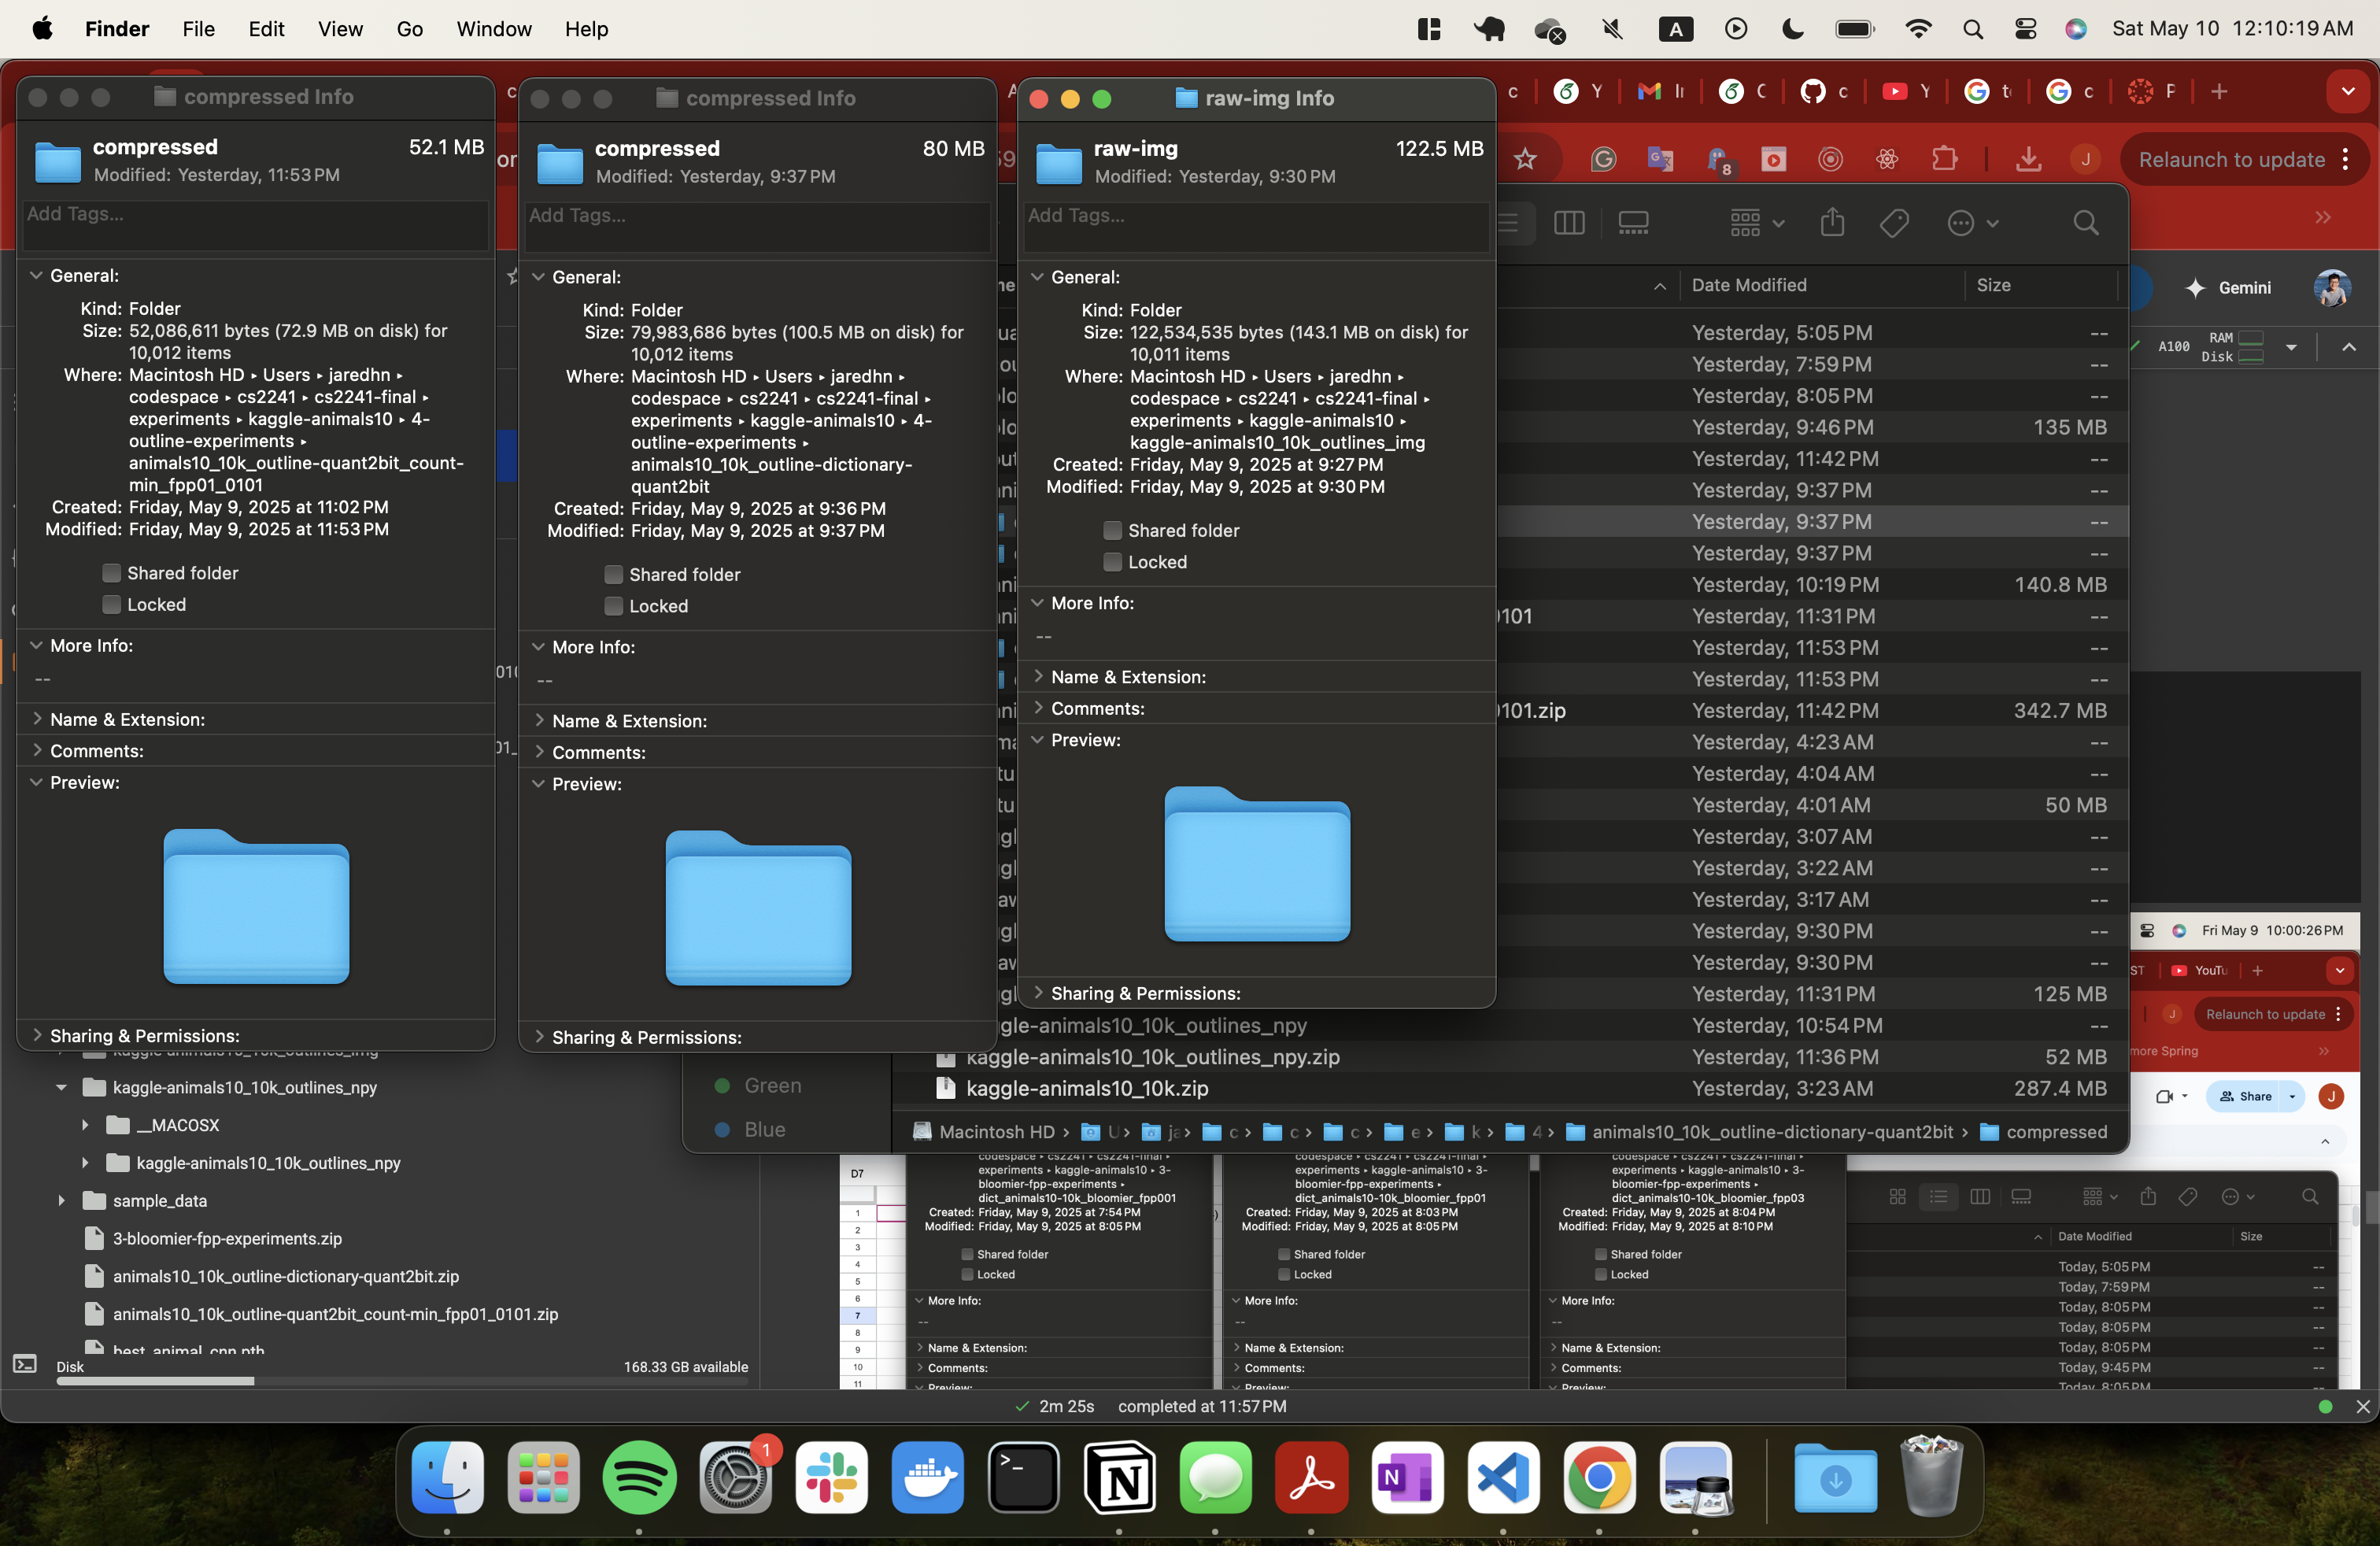

In [52]:
# SIZES FOR THE QUANTIZATION LEVELS:


from IPython.display import Image, display

# Replace 'screenshot.png' with the actual name of your uploaded file
file_name = 'size-files.png'
display(Image(filename=file_name))

# file_name = 'size_change-epp.png'
# display(Image(filename=file_name))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

input_size = (128, 128)
batch_size = 128

augmentor = ImageDataGenerator(samplewise_center=True,
                               samplewise_std_normalization=True)

train_generator = augmentor.flow_from_directory(
    '/kaggle/split_data/train',
    target_size=input_size,
    batch_size=batch_size,
    shuffle=True
)

val_generator = augmentor.flow_from_directory(
    '/kaggle/split_data/val',
    target_size=input_size,
    batch_size=batch_size,
    shuffle=False
)

test_generator = augmentor.flow_from_directory(
    '/kaggle/split_data/test',
    target_size=input_size,
    batch_size=batch_size,
    shuffle=False
)

Found 19998 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [ ]:
num_classes = len(train_generator.class_indices)
input_shape = (128,128,3)

2


In [ ]:
model = Sequential([
    Input(shape = input_shape),
    Conv2D (32, kernel_size = (3,3), activation= "relu"),
    Conv2D (32, kernel_size = (3,3), activation= "relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),


    Conv2D (64, kernel_size = (3,3), activation= "relu"),
    Conv2D (64, kernel_size = (3,3), activation= "relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),


    Conv2D (128, kernel_size = (3,3), activation= "relu"),
    Conv2D (128, kernel_size = (3,3), activation= "relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D (256, kernel_size = (3,3), activation= "relu"),
    Conv2D (256, kernel_size = (3,3), activation= "relu"),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation = 'relu'),
    Dense(128 , activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model.compile(optimizer='adam',
             loss= 'categorical_crossentropy',
             metrics =["accuracy"])
model.summary()

Model Layers:
0 conv2d N/A
1 conv2d_1 N/A
2 max_pooling2d N/A
3 dropout N/A
4 conv2d_2 N/A
5 conv2d_3 N/A
6 max_pooling2d_1 N/A
7 dropout_1 N/A
8 conv2d_4 N/A
9 conv2d_5 N/A
10 max_pooling2d_2 N/A
11 dropout_2 N/A
12 conv2d_6 N/A
13 conv2d_7 N/A
14 final_pool_layer N/A
15 dropout_3 N/A
16 flatten N/A
17 dense N/A
18 dense_1 N/A
19 dropout_4 N/A
20 dense_2 N/A


In [ ]:
model.fit(train_generator,
          epochs=15,
          validation_data=val_generator)

Epoch 1/15
  6/157 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - accuracy: 0.4882 - loss: 0.7747

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5164 - loss: 0.6986

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 67s 316ms/step - accuracy: 0.5167 - loss: 0.6984 - val_accuracy: 0.6452 - val_loss: 0.6299
Epoch 2/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.6764 - loss: 0.5975 - val_accuracy: 0.6960 - val_loss: 0.5981
Epoch 3/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.7258 - loss: 0.5476 - val_accuracy: 0.7588 - val_loss: 0.5115
Epoch 4/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 230ms/step - accuracy: 0.7601 - loss: 0.4934 - val_accuracy: 0.7696 - val_loss: 0.4738
Epoch 5/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.7958 - loss: 0.4378 - val_accuracy: 0.8096 - val_loss: 0.4096
Epoch 6/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 227ms/step - accuracy: 0.8291 - loss: 0.3863 - val_accuracy: 0.8372 - val_loss: 0.3638
Epoch 7/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.8541 - loss: 0.3394 - val_accuracy: 0.8708 - val_loss: 0.3125
Epoch 8/15
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 231ms/step - accuracy: 0.8712 - loss: 0.2992 - val

In [ ]:
try:
    # Try accessing the model's input tensor if build worked correctly
    # (This is what *should* work)
    model_input_tensor = model.input
    if model_input_tensor is None: # Check if it's None
         raise AttributeError # Force fallback if None
    print("Using model.input")
except AttributeError:
    try:
        # Fallback: If Input() is the first layer *in the list*:
        model_input_tensor = model.layers[0].output
        print("Using model.layers[0].output")
         # This might actually get the output of the *first Conv layer* if Input isn't counted
         # Need to be careful. Let's try model.inputs list
        if isinstance(model.inputs, list) and len(model.inputs) > 0:
             model_input_tensor = model.inputs[0]
             print("Using model.inputs[0]")
        else:
             # If the above fail, maybe the input layer NAME works?
             model_input_tensor = model.get_layer(index=0).output # Try getting layer 0 output by index
             print("Using model.get_layer(index=0).output")

    except Exception as e:
        print(f"Error getting input tensor: {e}")
        print("Could not reliably determine the input tensor. Consider defining Input() outside the Sequential list.")
        # Handle error appropriately - maybe exit or raise
        raise ValueError("Cannot find the input tensor for the feature extractor.") from e


# Identify the target layer by name (more robust)
target_layer_name = 'final_pool_layer'
target_output = model.get_layer(target_layer_name).output

# Create a new Model using the input tensor we found
feature_extractor_model = Model(inputs=model_input_tensor, outputs=target_output, name="feature_extractor")

print("\n--- Feature Extractor Model Summary ---")
# Need to build the extractor model too before summary sometimes
feature_extractor_model.build(input_shape=(None,) + input_shape)
feature_extractor_model.summary()

def load_and_preprocess_image(image_path, target_shape):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_shape[:2])
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

image_path = '/kaggle/split_data/test/Cat/100.jpg'
try:
    # Create a dummy image if needed for testing:
    dummy_data = np.random.rand(input_shape[0], input_shape[1], input_shape[2]) * 255
    tf.keras.preprocessing.image.save_img(image_path, dummy_data)
except Exception as e:
    print(f"Could not create dummy image: {e}. Please provide a real image path.")
    exit()


preprocessed_image = load_and_preprocess_image(image_path, input_shape)

# Use the feature_extractor_model to get the feature map
feature_map = feature_extractor_model.predict(preprocessed_image)

print(f"\nShape of extracted feature map: {feature_map.shape}")

# Clean up dummy image if created
import os
if os.path.exists(image_path):
    try:
        os.remove(image_path)
    except OSError as e:
        print(f"Error removing dummy image: {e}")
"""
0 conv2d_56 N/A
1 conv2d_57 N/A
2 max_pooling2d_23 N/A
3 dropout_35 N/A
4 conv2d_58 N/A
5 conv2d_59 N/A
6 max_pooling2d_24 N/A
7 dropout_36 N/A
8 conv2d_60 N/A
9 conv2d_61 N/A
10 max_pooling2d_25 N/A
11 dropout_37 N/A
12 conv2d_62 N/A
13 conv2d_63 N/A
14 final_pool_layer N/A
"""

Using model.layers[0].output
Using model.inputs[0]

--- Feature Extractor Model Summary ---


Model: "feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 124, 124, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 58, 58, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 29, 29, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 27, 27, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ final_pool_layer (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,172,256 (4.47 MB)

 Trainable params: 1,172,256 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step

Shape of extracted feature map: (1, 4, 4, 256)


'\n0 conv2d_56 N/A\n1 conv2d_57 N/A\n2 max_pooling2d_23 N/A\n3 dropout_35 N/A\n4 conv2d_58 N/A\n5 conv2d_59 N/A\n6 max_pooling2d_24 N/A\n7 dropout_36 N/A\n8 conv2d_60 N/A\n9 conv2d_61 N/A\n10 max_pooling2d_25 N/A\n11 dropout_37 N/A\n12 conv2d_62 N/A\n13 conv2d_63 N/A\n14 final_pool_layer N/A\n'

In [ ]:
# print(f"\nExtracted feature map: {feature_map}")

import numpy as np
import os # For checking file existence
import sys

log_filename = "inference_log.txt"
print(f"Attempting to write feature map details to '{log_filename}'...")


# Make sure feature_map exists before proceeding
if 'feature_map' not in locals() and 'feature_map' not in globals():
    print("Error: 'feature_map' variable not found. Please ensure it was generated.")
else:
    # --- WARNING ---
    total_elements = np.prod(feature_map.shape)
    print(f"[WARNING] Feature map has {total_elements} elements.")
    if total_elements > 10000: # Arbitrary threshold for warning
        print(f"[WARNING] Writing all elements might create a very large log file (> {total_elements * 5 // 1024} KB approx) and could be slow.")
    # -------------

    try:
        with open(log_filename, 'w') as log_file: # Use 'w' to overwrite each time for full logs
            log_file.write("--- Full Extracted Feature Map ---\n")
            log_file.write(f"Timestamp: {np.datetime64('now')}\n")
            log_file.write(f"Shape: {feature_map.shape}\n")
            log_file.write(f"Data Type: {feature_map.dtype}\n")
            log_file.write(f"Min value: {np.min(feature_map)}\n")
            log_file.write(f"Max value: {np.max(feature_map)}\n")
            log_file.write(f"Mean value: {np.mean(feature_map)}\n")
            log_file.write(f"Std Dev: {np.std(feature_map)}\n")
            log_file.write("\nFeature Map Content (Full):\n")

            # Option 2 (Modified): Write the FULL array content
            # Use threshold=sys.maxsize or np.inf to disable summarization
            feature_map_string = np.array2string(
                feature_map,
                precision=6,          # Increase precision if needed
                suppress_small=False, # Show small numbers accurately
                max_line_width=150,   # Wider lines might help for large arrays
                threshold=sys.maxsize # Force printing the entire array
                # threshold=np.inf   # Alternative way to force printing all
            )
            log_file.write(feature_map_string)

            log_file.write("\n--- End Full Feature Map ---\n")

        print(f"Successfully wrote FULL feature map to '{log_filename}'")

    except Exception as e:
        print(f"Error writing to log file '{log_filename}': {e}")

Attempting to write feature map details to 'inference_log.txt'...
Error: 'feature_map' variable not found. Please ensure it was generated.


In [ ]:
# --- 1. Create the "Classifier Head" Model ---

# Find the index of the layer RIGHT AFTER our feature extraction layer ('final_pool_layer')
# This is where the classifier head starts.
feature_layer_name = 'final_pool_layer'
try:
    # Find the index of the layer by name
    feature_layer_index = [i for i, layer in enumerate(model.layers) if layer.name == feature_layer_name][0]
    classifier_start_index = feature_layer_index + 1
    print(f"Feature extraction layer ('{feature_layer_name}') index: {feature_layer_index}")
    print(f"Classifier head starts at layer index: {classifier_start_index}")
except IndexError:
    print(f"Error: Could not find layer named '{feature_layer_name}' in the original model.")
    # Handle error appropriately
    exit()
except Exception as e:
    print(f"An error occurred finding the layer index: {e}")
    exit()


# Define an Input layer matching the shape of the feature map (excluding batch dimension)
feature_map_shape = feature_map.shape[1:]
classifier_input = Input(shape=feature_map_shape, name="feature_map_input")

# connect
x = classifier_input
for i in range(classifier_start_index, len(model.layers)):
    original_layer = model.layers[i]
    x = original_layer(x, training=False)
    print(f"Added layer {i}: {original_layer.name}")

classifier_model = Model(inputs=classifier_input, outputs=x, name="classifier_head")

print("\n--- Classifier Head Model Summary ---")
classifier_model.summary()

"""
15 dropout_33 N/A
16 flatten_6 N/A
17 dense_18 N/A
18 dense_19 N/A
19 dropout_34 N/A
20 dense_20 N/A
"""

Feature extraction layer ('final_pool_layer') index: 14
Classifier head starts at layer index: 15
Added layer 15: dropout_38
Added layer 16: flatten_7
Added layer 17: dense_21
Added layer 18: dense_22
Added layer 19: dropout_39
Added layer 20: dense_23

--- Classifier Head Model Summary ---


Model: "classifier_head"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ feature_map_input (InputLayer)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,081,986 (4.13 MB)

 Trainable params: 1,081,986 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

'\n15 dropout_33 N/A\n16 flatten_6 N/A\n17 dense_18 N/A\n18 dense_19 N/A\n19 dropout_34 N/A\n20 dense_20 N/A\n'

In [ ]:

final_predictions = classifier_model.predict(feature_map)

print(f"\nShape of final predictions: {final_predictions.shape}") # Should be (1, num_classes)
print(f"Raw predictions (probabilities):\n{final_predictions}")

predicted_class_index = np.argmax(final_predictions, axis=1)[0]
print(f"\nPredicted class index: {predicted_class_index}")

print("\n--- Verifying with original model ---")

# (Need to load the image again if not available)
image_path = '/kaggle/split_data/test/Cat/11530.jpg'

if not os.path.exists(image_path):
    try:
        print("Creating dummy image for verification...")
        dummy_data = np.random.rand(input_shape[0], input_shape[1], input_shape[2]) * 255
        tf.keras.preprocessing.image.save_img(image_path, dummy_data)
    except Exception as e:
        print(f"Could not create dummy image: {e}.")
else:
    def load_and_preprocess_image(image_path, target_shape):
        img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_shape[:2])
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = img_array / 255.0
        return img_array

    preprocessed_image_for_full_model = load_and_preprocess_image(image_path, input_shape)
    original_model_predictions = model.predict(preprocessed_image_for_full_model)
    original_predicted_class_index = np.argmax(original_model_predictions, axis=1)[0]

    print(f"Original model predicted index: {original_predicted_class_index}")
    print(f"Feature map pipeline predicted index: {predicted_class_index}")

    # Check if predictions are numerically close (they should be almost identical)
    if np.allclose(final_predictions, original_model_predictions, atol=1e-6):
        print("SUCCESS: Predictions from split model match original model (before compression).")
    else:
        print("WARNING: Predictions from split model DO NOT match original model.")
        print("Original:", original_model_predictions)
        print("Split:", final_predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Shape of final predictions: (1, 2)
Raw predictions (probabilities):
[[0.75012386 0.24987611]]

Predicted class index: 0

--- Verifying with original model ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Original model predicted index: 0
Feature map pipeline predicted index: 0
Original: [[0.7234268  0.27657315]]
Split: [[0.75012386 0.24987611]]
